In [1]:
from copy import deepcopy
import numpy as np
import plotly.graph_objects as go

class DisplayFigs:
    def _rgb_to_hex(rgb):
        '''Convert colors to Plotly hex color strings'''
        rgb255 = (rgb * 255).astype(int)
        return ['rgb({},{},{})'.format(r, g, b) for r, g, b in rgb255]


    def display_plotly_orig_and_clouds(orig_fig, cloud_figs: set):
        # Extract metadata for origin figure
        verts_fig = np.asarray(orig_fig.vertices)
        tris_fig = np.asarray(orig_fig.triangles)
        orig_colors = np.asarray(orig_fig.vertex_colors) if orig_fig.has_vertex_colors() else np.full(verts_fig.shape, [128/255, 26/255, 107/255])

        # Exrtact metadata for cloud figures
        cloud_figs_points = []
        cloud_figs_colors_hex = []
        for cloud_fig in cloud_figs:
            cloud_figs_points.append(np.asarray(cloud_fig.points))

            fig_colors = np.asarray(cloud_fig.colors) if cloud_fig.has_colors() else np.tile([0, 0, 1], (len(cloud_fig.points), 1))
        
            cloud_figs_colors_hex.append(DisplayFigs._rgb_to_hex(fig_colors))

        orig_trace = go.Mesh3d(
            x=verts_fig[:, 0], y=verts_fig[:, 1], z=verts_fig[:, 2],
            i=tris_fig[:, 0], j=tris_fig[:, 1], k=tris_fig[:, 2],
            vertexcolor=orig_colors,
            opacity=0.8,
            showlegend=False,
            name=''
        )

        cloud_figs_trace = []
        for points, colors in zip(cloud_figs_points, cloud_figs_colors_hex):
            cloud_figs_trace.append(go.Scatter3d(
                x=points[:, 0], y=points[:, 1], z=points[:, 2],
                mode='markers',
                marker=dict(size=2, color=colors),
                showlegend=False,
                name=''
            ))

        merged_trace = [orig_trace,] + cloud_figs_trace

        fig = go.Figure(data=merged_trace)

        fig.update_layout(
            showlegend=False,
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode='data'
            ),
            margin=dict(t=0, l=0, r=0, b=0)
        )

        fig.show(config={'displayModeBar': False})


    def display_plotly_origs(orig_figs: set, offset_step=1.0):
        traces = []
        for idx, orig_fig in enumerate(orig_figs):
            vertices = np.asarray(orig_fig.vertices)
            triangles = np.asarray(orig_fig.triangles)
            color = np.asarray(orig_fig.vertex_colors) if orig_fig.has_vertex_colors() else np.full(vertices.shape, [128/255, 26/255, 107/255])

            # Apply offset to vertices along x-axis:
            offset = np.array([offset_step * idx, 0, 0])
            vertices_offset = vertices + offset

            traces.append(
                go.Mesh3d(
                    x=vertices_offset[:, 0], y=vertices_offset[:, 1], z=vertices_offset[:, 2],
                    i=triangles[:, 0], j=triangles[:, 1], k=triangles[:, 2],
                    vertexcolor=color,
                    opacity=0.8,
                    showlegend=False,
                    name=''
                )
            )

        fig = go.Figure(data=traces)

        fig.update_layout(
            showlegend=False,
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode='data'
            ),
            margin=dict(t=0, l=0, r=0, b=0)
        )

        fig.show(config={'displayModeBar': False})


    def display_plotly_clouds(cloud_figs: set, non_in_line=False, offset_step=3.0):
        cloud_figs_trace = []
        for i, cloud_fig in enumerate(cloud_figs):
            points = np.asarray(cloud_fig.points)
            color = DisplayFigs._rgb_to_hex(
                np.asarray(cloud_fig.colors) if cloud_fig.has_colors() else np.tile([1.0, 0.75, 0.0], (len(cloud_fig.points), 1))
            )

            offset_points = deepcopy(points)
            if non_in_line:
                offset_points[:, 0] += i * offset_step

            cloud_figs_trace.append(go.Scatter3d(
                x=offset_points[:, 0], y=offset_points[:, 1], z=offset_points[:, 2],
                mode='markers',
                marker=dict(size=2, color=color),
                showlegend=False,
                name=''
            ))

        fig = go.Figure(data=cloud_figs_trace)

        fig.update_layout(
            showlegend=False,
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode='data'
            ),
            margin=dict(t=0, l=0, r=0, b=0)
        )

        fig.show(config={'displayModeBar': False})

# Семинар: Сопоставление с шаблоном (Registration) в Open3D

In [2]:
import copy
import time

import open3d as o3d
import numpy as np

## 1. ICP

Входными данными служат два облака точек и начальное преобразование, которое приблизительно совмещает исходное облако точек с целевым. На выходе получается уточнённое преобразование, которое плотно совмещает два облака точек.

Основная идея ICP:
* 1. Выбираем две точки облака: источник (source) и цель (target).
* 2. Для каждой точки из source находим ближайшую точку в target.
* 3. Находим оптимальное преобразование (вращение + перенос), минимизирующее расстояние между парами точек.
* 4. Применяем преобразование к source.
* 5. Повторяем шаги 2–4 до сходимости.

In [7]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)

    DisplayFigs.display_plotly_origs
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=0.4459,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])

## Входные данные
Приведённый ниже код считывает исходное и целевое облака точек из двух файлов. Приведен пример грубого преобразования.

In [8]:
demo_icp_pcds = o3d.data.DemoICPPointClouds()
source = o3d.io.read_point_cloud(demo_icp_pcds.paths[0])
target = o3d.io.read_point_cloud(demo_icp_pcds.paths[1])
threshold = 0.02
trans_init = np.asarray([[0.862, 0.011, -0.507, 0.5],
                         [-0.139, 0.967, -0.215, 0.7],
                         [0.487, 0.255, 0.835, -1.4],
                         [0.0, 0.0, 0.0, 1.0]])

draw_registration_result(source, target, trans_init)

[Open3D INFO] Downloading https://github.com/isl-org/open3d_downloads/releases/download/20220301-data/DemoICPPointClouds.zip
[Open3D INFO] Downloaded to /Users/polina/open3d_data/download/DemoICPPointClouds/DemoICPPointClouds.zip
[Open3D INFO] Created directory /Users/polina/open3d_data/extract/DemoICPPointClouds.
[Open3D INFO] Extracting /Users/polina/open3d_data/download/DemoICPPointClouds/DemoICPPointClouds.zip.
[Open3D INFO] Extracted to /Users/polina/open3d_data/extract/DemoICPPointClouds.


In [9]:
o3d.visualization.draw_geometries([target, source])

2025-11-06 21:35:14.735 Python[34048:1000395] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


In [10]:
o3d.visualization.draw_geometries([target])
o3d.visualization.draw_geometries([source])

In [6]:
pts = np.asarray(source.points)
extent = pts.max(axis=0) - pts.min(axis=0)
print("Размеры по осям (X, Y, Z):", extent)
print("Диагональ сцены:", np.linalg.norm(extent))

Размеры по осям (X, Y, Z): [3.40999055 1.5928688  1.99506235]
Диагональ сцены: 4.259758251341644


### Функция evaluate_registration вычисляет два основных показателя:

* fitness — измеряет площадь перекрытия (количество внутренних соответствий / количество точек в исходном облаке). Чем выше значение, тем лучше.

* inlier_rmse — вычисляет среднеквадратичную ошибку (RMSE) всех внутренних соответствий. Чем ниже значение, тем лучше.

### Параметры функции `evaluate_registration`

**source** (`open3d.geometry.PointCloud`)  
Исходное облако точек — то, которое нужно совместить с целевым (`target`).  

**target** (`open3d.geometry.PointCloud`)  
Целевое (опорное) облако точек, с которым сравнивается `source`.  

**max_correspondence_distance** (`float`)  
Максимальное расстояние, на котором точки из `source` и `target` считаются совпадающими.  
Если расстояние между парой точек больше этого порога — она не учитывается при расчёте метрик.  
Обычно подбирается исходя из масштаба облака, например `0.02` для моделей, нормализованных в метрах.  

**transformation** (`numpy.ndarray` формы `(4, 4)`)  
4×4 матрица преобразования, которая применяется к `source` перед сравнением.  
В ней закодированы вращение, перенос (и при необходимости масштаб).  
Если не указана — используется единичная матрица, то есть `source` сравнивается с `target` без трансформации.


### 1. **Fitness**

$$
\text{fitness} = \frac{N_{\text{inlier}}}{N_{\text{source}}}
$$

где

* $N_{\text{inlier}}$ — количество точек исходного облака, для которых удалось найти соответствия в целевом облаке в пределах заданного радиуса (порог близости);
* $N_{\text{source}}$ — общее количество точек в исходном облаке.

### 2. **Inlier RMSE**

$$
\text{inlier\_rmse} = \sqrt{\frac{1}{N_{\text{inlier}}} \sum_{(p_i, q_i) \in \text{inliers}} \|\,p_i - q_i\,\|^2 }
$$

где

* $p_i$ — точка из исходного облака после трансформации,
* $q_i$ — соответствующая точка из целевого облака,
* $\|p_i - q_i\|$ — евклидово расстояние между точками,
* усреднение выполняется только по inliers (точкам, попавшим в радиус допустимого соответствия).


In [7]:
threshold = 0.05

evaluation = o3d.pipelines.registration.evaluate_registration(
    source=source,
    target=target,
    max_correspondence_distance=threshold,
    transformation=trans_init
    )

print(f'Fitness={round(evaluation.fitness, 3)}')
print(f'Inlier_rmse={round(evaluation.inlier_rmse, 3)}')
print(f'correspondence_set is {len(evaluation.correspondence_set)}/{len(source.points)}')
print(f'Transform:\n{evaluation.transformation}')

Fitness=0.381
Inlier_rmse=0.027
correspondence_set is 75779/198835
Transform:
[[ 0.862  0.011 -0.507  0.5  ]
 [-0.139  0.967 -0.215  0.7  ]
 [ 0.487  0.255  0.835 -1.4  ]
 [ 0.     0.     0.     1.   ]]


## **Point-to-point ICP (точка-к-точке ICP)**

В общем виде алгоритм ICP выполняет итерации из двух шагов:

1. **Поиск множества соответствий** между точками целевого облака и точками исходного облака, преобразованного с помощью текущей матрицы трансформации.
2. **Обновление матрицы трансформации** путём минимизации целевой функции, определённой на множестве соответствий.

Сначала рассмотрим алгоритм **point-to-point ICP**, в котором минимизируется следующая целевая функция:

$$
E(R, t) = \sum_{(p_i, q_i) \in \mathcal{C}} \| R p_i + t - q_i \|^2
$$

где

* $p_i$ — точки исходного облака,
* $q_i$ — соответствующие точки целевого облака,
* $R, t$ — матрица поворота и вектор сдвига, составляющие искомое преобразование,
* $\mathcal{C}$ — множество соответствий.

Класс **TransformationEstimationPointToPoint** реализует функции для вычисления функции потерь.

Функция **registration\_icp** принимает этот класс в качестве параметра и запускает ICP по схеме «точка-к-точке» для получения результата.


### Сигнатура метода registration_icp()

```
o3d.pipelines.registration.registration_icp(
    source: open3d.geometry.PointCloud,
    target: open3d.geometry.PointCloud,
    max_correspondence_distance: float,
    init: numpy.ndarray = np.identity(4),
    estimation_method: TransformationEstimation = TransformationEstimationPointToPoint(),
    criteria: ICPConvergenceCriteria = ICPConvergenceCriteria()
) -> RegistrationResult
```

### Аргументы:

1. **`source`** (`open3d.geometry.PointCloud`)
   Исходное облако точек, которое мы хотим совместить с целевым.

2. **`target`** (`open3d.geometry.PointCloud`)
   Целевое облако точек, с которым совмещается `source`.

3. **`max_correspondence_distance`** (`float`)
   Максимальное расстояние для поиска соответствующих точек.

   * Если точка из `source` не находит точку в `target` ближе, чем это значение - она считается «выбросом» и не участвует в итерации.
   * Чем меньше порог, тем строже соответствие (быстрее и точнее, но выше риск игнорирования полезных точек).

4. **`init`** (`numpy.ndarray`, 4×4 матрица, по умолчанию `np.identity(4)`)
   Начальная трансформация (приближение).

   * Если ничего не указано - берётся единичная матрица (совпадение в исходных координатах).
   * Если заранее известно приблизительное смещение - лучше передать его сюда для ускорения сходимости.

5. **`estimation_method`** (`TransformationEstimation`, по умолчанию `TransformationEstimationPointToPoint()`)
   Определяет целевую функцию ICP. Варианты:

   * `TransformationEstimationPointToPoint()` — классический вариант (минимизация расстояний между точками).
   * `TransformationEstimationPointToPlane()` — более точный вариант с учётом нормалей (минимизация расстояния до плоскости).
   * `TransformationEstimationPointToPlane(loss)` — с устойчивыми ядрами (для работы с шумом и выбросами).

6. **`criteria`** (`ICPConvergenceCriteria`, по умолчанию `ICPConvergenceCriteria()`)
   Критерии остановки ICP. Можно задать:

   * `max_iteration` — максимальное количество итераций (по умолчанию 30).
   * `relative_fitness` — минимальное изменение fitness между итерациями для остановки.
   * `relative_rmse` — минимальное изменение RMSE между итерациями.

### Возвращаемое значение:

**`RegistrationResult`**, содержащий:

* `transformation` — итоговая матрица 4×4, найденная ICP,
* `fitness` — доля совпавших точек (inliers / все точки),
* `inlier_rmse` — среднеквадратичная ошибка для совпавших точек,
* `correspondence_set` — соответствия точек (можно использовать для анализа).

In [8]:
threshold = 0.05

print("Apply point-to-point ICP")
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint())

print(f'Fitness={round(reg_p2p.fitness, 3)}')
print(f'Inlier_rmse={round(reg_p2p.inlier_rmse, 3)}')
print(f'correspondence_set is {len(reg_p2p.correspondence_set)}/{len(source.points)}')
print(f'Transform:\n{reg_p2p.transformation}')

draw_registration_result(source, target, reg_p2p.transformation)

Apply point-to-point ICP
Fitness=0.647
Inlier_rmse=0.009
correspondence_set is 128561/198835
Transform:
[[ 0.84072261  0.00853426 -0.54164801  0.64180491]
 [-0.1493574   0.96515739 -0.21635562  0.81419363]
 [ 0.52001141  0.26197974  0.81259257 -1.48069155]
 [ 0.          0.          0.          1.        ]]


По умолчанию функция **registration\_icp** работает до сходимости либо до достижения максимального числа итераций (по умолчанию 30). Этот параметр можно изменить, чтобы выделить больше времени на вычисления и получить более точный результат.


In [9]:
threshold = 0.05

reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=5))

print(f'Fitness={round(reg_p2p.fitness, 3)}')
print(f'Inlier_rmse={round(reg_p2p.inlier_rmse, 3)}')
print(f'correspondence_set is {len(reg_p2p.correspondence_set)}/{len(source.points)}')
print(f'Transform:\n{reg_p2p.transformation}')

draw_registration_result(source, target, reg_p2p.transformation)

Fitness=0.525
Inlier_rmse=0.026
correspondence_set is 104462/198835
Transform:
[[ 0.85054986  0.00362934 -0.52611857  0.59065131]
 [-0.15324011  0.95873758 -0.2408571   0.80869228]
 [ 0.50260959  0.28468242  0.81589589 -1.4862909 ]
 [ 0.          0.          0.          1.        ]]


## **Point-to-plane ICP (точка-к-плоскости ICP)**

Алгоритм point-to-plane ICP использует другую целевую функцию:

$$
E(R, t) = \sum_{(p_i, q_i) \in \mathcal{C}} \big( n_i^\top (R p_i + t - q_i) \big)^2
$$

где

* $p_i$ — точка исходного облака,
* $q_i$ — соответствующая точка целевого облака,
* $n_i$ — нормаль в точке $q_i$.

Опыт исследователей показал, что алгоритм point-to-plane ICP сходится быстрее, чем point-to-point ICP.

Функция **registration\_icp** вызывается с другим параметром — **TransformationEstimationPointToPlane**.
Внутри этот класс реализует вычисление ошибок соответствия (residuals) и матриц Якоби для целевой функции point-to-plane ICP.


In [10]:
threshold = 0.05

print("Apply point-to-plane ICP")
reg_p2l = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPlane(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=100))

print(f'Fitness={round(reg_p2l.fitness, 3)}')
print(f'Inlier_rmse={round(reg_p2l.inlier_rmse, 3)}')
print(f'correspondence_set is {len(reg_p2l.correspondence_set)}/{len(source.points)}')
print(f'Transform:\n{reg_p2l.transformation}')

draw_registration_result(source, target, reg_p2l.transformation)

Apply point-to-plane ICP
Fitness=0.646
Inlier_rmse=0.009
correspondence_set is 128495/198835
Transform:
[[ 0.84042116  0.00664126 -0.54214394  0.64529287]
 [-0.14792251  0.96518393 -0.21722003  0.8113156 ]
 [ 0.52090806  0.26193678  0.81203104 -1.48278642]
 [ 0.          0.          0.          1.        ]]


## Point-to-Point ICP

**Целевая функция:**

$$
E(R, t) = \sum_{(p_i, q_i) \in \mathcal{C}} \| R p_i + t - q_i \|^2
$$

* Мы минимизируем **евклидово расстояние между точками**.
* Ошибка — это просто как далеко одна точка от другой.
* Подходит, когда у нас:

  * облака точек **редкие или шумные**,
  * **нет нормалей** (например, у нас есть только координаты точек),
  * мы хотим максимально простую и устойчивую настройку.

Недостаток — **сходимость медленная**, особенно когда поверхности гладкие и почти совпадают, но точки не идеально попадают друг в друга.


## Point-to-Plane ICP

**Целевая функция:**

$$
E(R, t) = \sum_{(p_i, q_i) \in \mathcal{C}} \big( n_i^\top (R p_i + t - q_i) \big)^2
$$

* Мы минимизируем **расстояние вдоль нормали поверхности**.
* Ошибка — это насколько далеко точка отклоняется от поверхности, а не от конкретной точки.
* Подходит, когда:

  * у облаков есть хорошие **оценки нормалей**,
  * поверхности **гладкие и плотные**,
  * нужно быстрое и точное совмещение.

Плюсы — **сходимость быстрее** и результат точнее, особенно для плотных облаков (например, из RGBD-камер).
Минусы — чувствителен к неправильным нормалям: если они посчитаны плохо, результат может быть хуже, чем у point-to-point.

# Устойчивые ядра (Robust kernels)

В этом учебном примере рассматривается модифицированный алгоритм ICP (Iterative Closest Point), в который интегрированы устойчивые ядра для обработки выбросов. Такая версия ICP позволяет снижать влияние точек-аномалий при регистрации облаков точек, обеспечивая более надёжное и точное совмещение.

Хотя подход с устойчивыми ядрами может использоваться и в других задачах оптимизации, в Open3D он реализован только для варианта Point-to-Plane ICP.

# Как использовать устойчивые ядра в Open3D

**Point-to-plane ICP с использованием устойчивых ядер**

Стандартный алгоритм point-to-plane ICP минимизирует следующую целевую функцию:

$$
E(R, t) = \sum_{(p_i, q_i) \in \mathcal{C}} \big( n_i^\top (R p_i + t - q_i) \big)^2
$$

где

* $n_i$ — нормаль в точке $q_i$,
* $\mathcal{C}$ — множество соответствий между целевым облаком точек $Q$ и исходным облаком точек $P$.

Если определить

$$
r_i = n_i^\top (R p_i + t - q_i)
$$

как **остаток (residual)** для пары соответствий $(p_i, q_i)$, то функцию можно записать как:

$$
E(R, t) = \sum_{i=1}^{N} r_i^2
$$

## Отбрасывание выбросов с помощью устойчивых ядер

Основная идея **устойчивой функции потерь (robust loss, или ядра)** — **понижать вес больших остатков**, которые, как предполагается, вызваны выбросами. Это уменьшает их влияние на решение.

Задача формулируется так:

$$
E(R, t) = \sum_{i=1}^{N} \rho(r_i)
$$

где $\rho(\cdot)$ — устойчивая функция потерь (robust kernel).

Функцию **registration\_icp** можно вызвать с параметром **TransformationEstimationPointToPlane(loss)**, где `loss` — это выбранная функция потерь (устойчивое ядро).

Внутри Open3D класс **TransformationEstimationPointToPlane(loss)** реализует вычисление **взвешенных остатков и матриц Якоби** для целевой функции point-to-plane ICP в соответствии с заданным ядром.

### Tukey loss

$
\begin{split}\begin{equation}
  \rho(r)=
  \begin{cases}
    \frac{k^2\left[1-\left(1-\left(\frac{r}{k}\right)^2\right)^3\right]}{2}, & |r| \leq k.       \\
    \frac{k^2}{2},                                                           & \text{otherwise}.
  \end{cases}
\end{equation}\end{split}
$

$
\begin{split}\begin{equation}
  w(r)=
  \begin{cases}
    \left(1 - \left(\frac{r}{k}\right)^2\right)^2, & |r| \leq k.       \\
    0 ,                                            & \text{otherwise}.
  \end{cases}
\end{equation}\end{split}
$

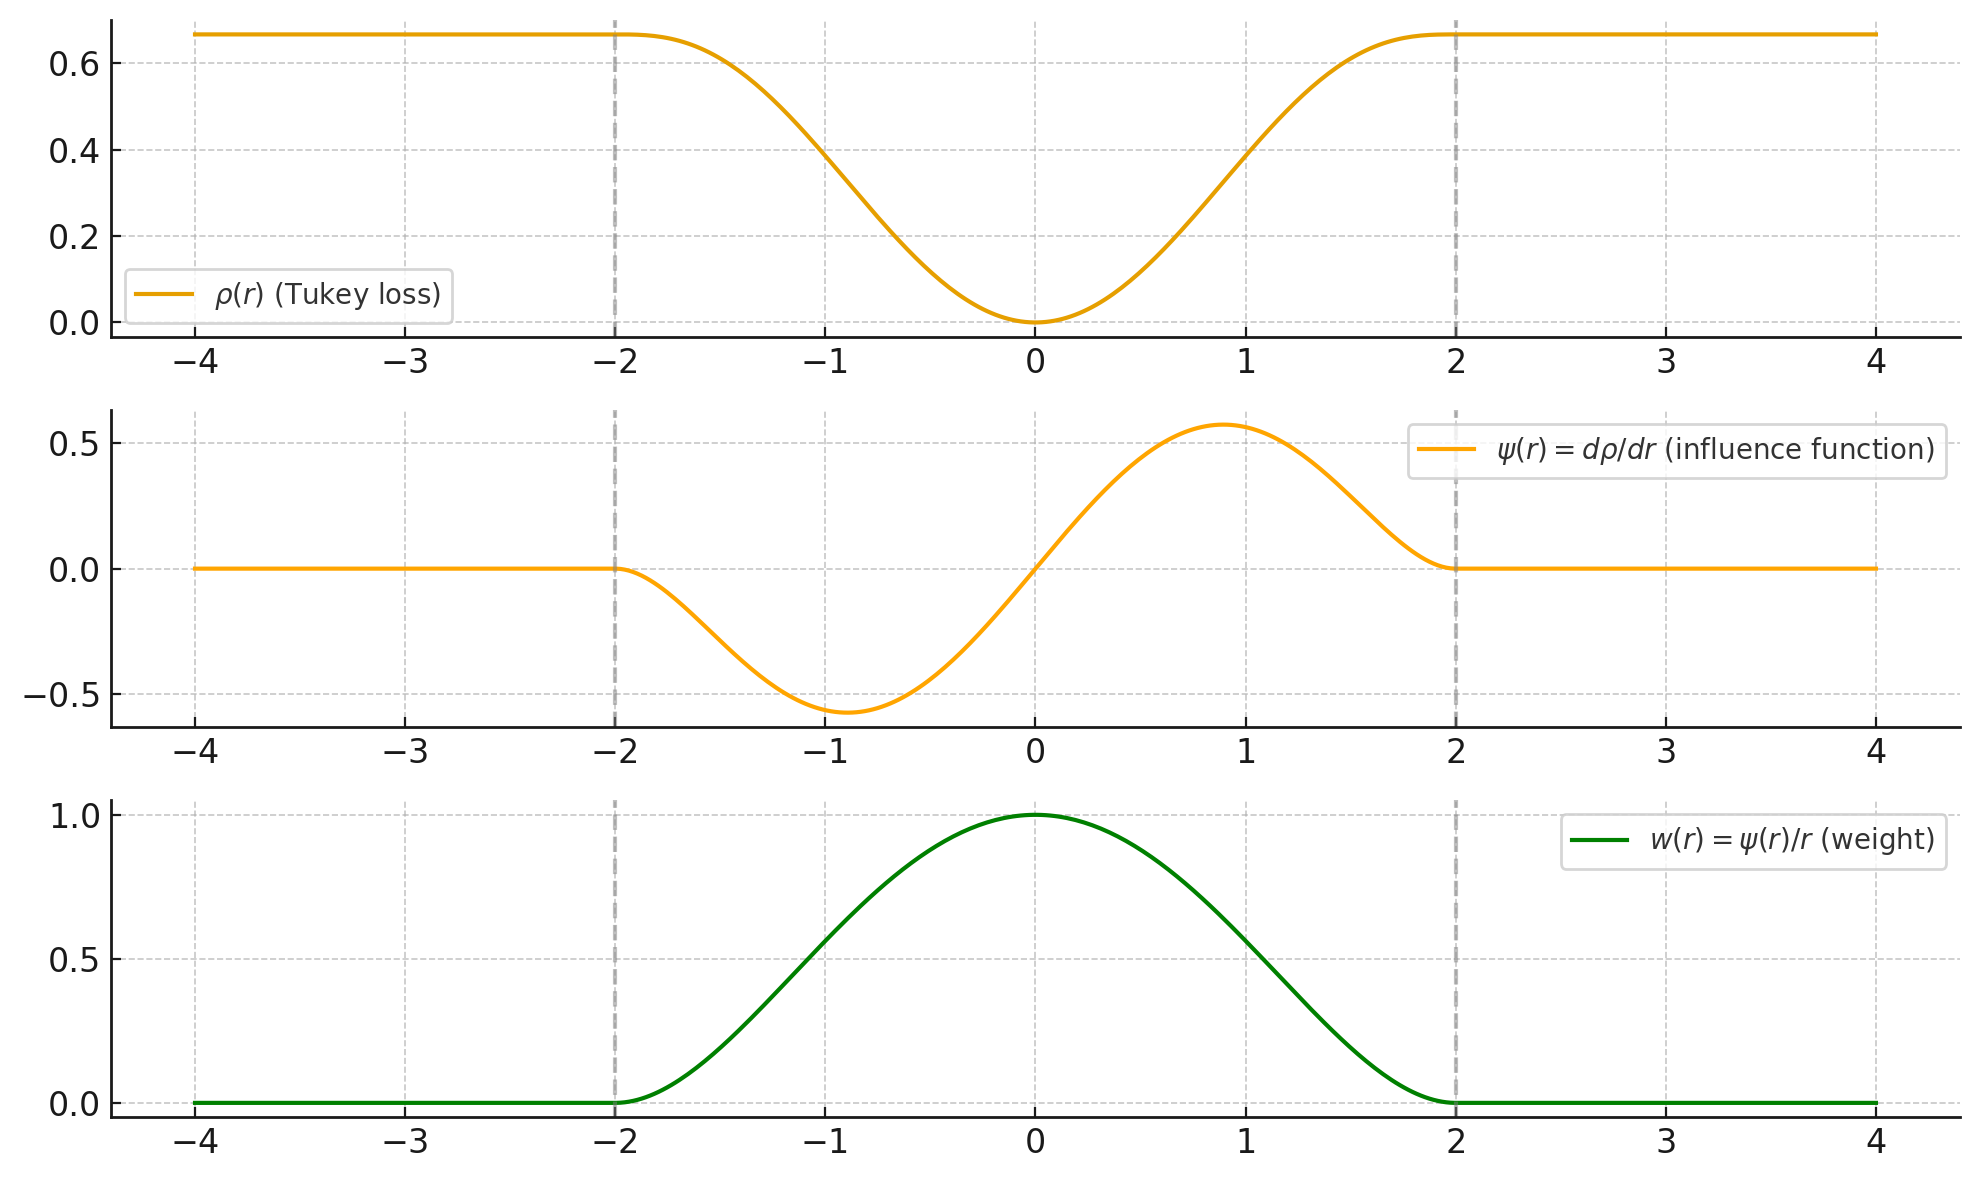

## Обычный ICP vs ICP с устойчивыми ядрами

Чтобы нагляднее показать преимущества использования устойчивых ядер при регистрации, в исходное облако точек специально добавляется искусственный гауссовский шум.


In [11]:
def apply_noise(pcd, mu, sigma):
    noisy_pcd = copy.deepcopy(pcd)
    points = np.asarray(noisy_pcd.points)
    points += np.random.normal(mu, sigma, size=points.shape)
    noisy_pcd.points = o3d.utility.Vector3dVector(points)
    return noisy_pcd


mu, sigma = 0, 0.1  # mean and standard deviation
source_noisy = apply_noise(source, mu, sigma)

o3d.visualization.draw_geometries([source_noisy],
                                  zoom=0.4459,
                                  front=[0.353, -0.469, -0.809],
                                  lookat=[2.343, 2.217, 1.809],
                                  up=[-0.097, -0.879, 0.467])

### Обычный ICP

In [12]:
threshold = 0.05

p2l = o3d.pipelines.registration.TransformationEstimationPointToPlane()
reg_p2l = o3d.pipelines.registration.registration_icp(source_noisy, target,
                                                      threshold, trans_init,
                                                      p2l)
print(f'Fitness={round(reg_p2l.fitness, 3)}')
print(f'Inlier_rmse={round(reg_p2l.inlier_rmse, 3)}')
print(f'correspondence_set is {len(reg_p2l.correspondence_set)}/{len(source.points)}')
print(f'Transform:\n{reg_p2l.transformation}')

draw_registration_result(source, target, reg_p2l.transformation)

Fitness=0.26
Inlier_rmse=0.029
correspondence_set is 51789/198835
Transform:
[[ 8.38250432e-01  6.07152402e-04 -5.45542742e-01  6.18272229e-01]
 [-1.53334391e-01  9.60342652e-01 -2.34301181e-01  8.45836585e-01]
 [ 5.22837238e-01  2.79242944e-01  8.04975200e-01 -1.51766367e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


### Настройка обычного ICP

Так как теперь мы имеем дело с гауссовским шумом, можно попробовать увеличить порог поиска ближайших соседей, чтобы улучшить результат регистрации.

Однако видно, что в таких условиях и без использования устойчивого ядра традиционный ICP не справляется с выбросами.

In [13]:
threshold = 1

p2l = o3d.pipelines.registration.TransformationEstimationPointToPlane()
reg_p2l = o3d.pipelines.registration.registration_icp(source_noisy, target,
                                                      threshold, trans_init,
                                                      p2l)

print(f'Fitness={round(reg_p2l.fitness, 3)}')
print(f'Inlier_rmse={round(reg_p2l.inlier_rmse, 3)}')
print(f'correspondence_set is {len(reg_p2l.correspondence_set)}/{len(source.points)}')
print(f'Transform:\n{reg_p2l.transformation}')

# draw_registration_result(source, target, reg_p2l.transformation)

Fitness=1.0
Inlier_rmse=0.242
correspondence_set is 198835/198835
Transform:
[[ 0.79335771  0.06551689 -0.60550143  1.53350475]
 [-0.29563054  0.91103762 -0.28882022  1.25897223]
 [ 0.53171434  0.40737328  0.74192311 -1.47406564]
 [ 0.          0.          0.          1.        ]]


## ICP с устойчивыми ядрами

При том же пороге поиска (threshold = 1.0), но с применением устойчивого ядра, два облака точек корректно совмещаются.

In [14]:
loss = o3d.pipelines.registration.TukeyLoss(k=sigma)

p2l = o3d.pipelines.registration.TransformationEstimationPointToPlane(loss)
reg_p2l = o3d.pipelines.registration.registration_icp(source_noisy, target,
                                                      threshold, trans_init,
                                                      p2l)

print(f'Fitness={round(reg_p2l.fitness, 3)}')
print(f'Inlier_rmse={round(reg_p2l.inlier_rmse, 3)}')
print(f'correspondence_set is {len(reg_p2l.correspondence_set)}/{len(source.points)}')
print(f'Transform:\n{reg_p2l.transformation}')

draw_registration_result(source, target, reg_p2l.transformation)

Fitness=0.936
Inlier_rmse=0.336
correspondence_set is 186177/198835
Transform:
[[ 0.83057813  0.03198634 -0.5562331   0.62461897]
 [-0.18026342  0.9604656  -0.21373517  0.89929825]
 [ 0.52647799  0.2769796   0.80338099 -1.52228224]
 [ 0.          0.          0.          1.        ]]


### Выводы

#### Что делает устойчивое ядро?

* В обычном ICP все ошибки (residuals) считаются одинаково важными.
* Но если есть шум или выбросы, то точки-аномалии могут сильно испортить результат.
* Устойчивое ядро (например, Tukey, Huber, Cauchy) «снижает вес» больших ошибок.

#### Зачем нужен параметр $k$?

$k$ — это **граница между нормальными данными и выбросами(шумными точками)**:

* Если ошибка $r_i$ маленькая ($|r_i| < k$), точка считается **inlier** → она учитывается почти полностью.
* Если ошибка большая ($|r_i| > k$), точка считается **outlier** → её вес резко уменьшается (почти игнорируется).

#### Как выбирать $k$?

* Обычно берут $k \approx \sigma$, где $\sigma$ — стандартное отклонение шума в данных.
* Тогда средний шум считается допустимым, а слишком большие отклонения автоматически попадают в outliers.
* То есть $k$ = «шумовой фильтр» для ICP.

## Регистрация цветных облаков точек

В этом учебном примере рассматривается модифицированный вариант ICP, который использует как геометрию, так и цвет для регистрации.

Цветовая информация фиксирует совмещение вдоль касательной плоскости. Благодаря этому данный алгоритм работает точнее и устойчивее, чем классические методы регистрации облаков точек, при этом скорость работы сопоставима с обычным ICP.

In [15]:
def draw_registration_result_original_color(source, target, transformation):
    source_temp = copy.deepcopy(source)
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target],
                                      zoom=0.5,
                                      front=[-0.2458, -0.8088, 0.5342],
                                      lookat=[1.7745, 2.2305, 0.9787],
                                      up=[0.3109, -0.5878, -0.7468])

In [16]:
demo_colored_icp_pcds = o3d.data.DemoColoredICPPointClouds()
source = o3d.io.read_point_cloud(demo_colored_icp_pcds.paths[0])
target = o3d.io.read_point_cloud(demo_colored_icp_pcds.paths[1])

current_transformation = np.identity(4)
draw_registration_result_original_color(source, target, current_transformation)

In [17]:
o3d.visualization.draw_geometries([source])
o3d.visualization.draw_geometries([target])

Сначала запускаем Point-to-plane ICP в качестве базового подхода.

На визуализации ниже видно смещение зелёных текстур треугольников.

Это происходит потому, что одних лишь геометрических ограничений недостаточно, чтобы предотвратить «скольжение» двух плоских поверхностей друг относительно друга.

In [18]:
current_transformation = np.identity(4)

result_icp = o3d.pipelines.registration.registration_icp(
    source, target, 0.02, current_transformation,
    o3d.pipelines.registration.TransformationEstimationPointToPlane())

print(f'Fitness={round(result_icp.fitness, 3)}')
print(f'Inlier_rmse={round(result_icp.inlier_rmse, 3)}')
print(f'correspondence_set is {len(result_icp.correspondence_set)}/{len(source.points)}')
print(f'Transform:\n{result_icp.transformation}')

draw_registration_result_original_color(source, target,
                                        result_icp.transformation)

Fitness=0.975
Inlier_rmse=0.004
correspondence_set is 62729/64365
Transform:
[[ 0.99829734 -0.05717925 -0.01153079  0.11343692]
 [ 0.05759686  0.99754233  0.03989875  0.12506922]
 [ 0.00922107 -0.04049496  0.99913719  0.16456626]
 [ 0.          0.          0.          1.        ]]


### Регистрация цветных облаков точек

Основная функция для цветной регистрации облаков точек в Open3D — `registration_colored_icp`.

Она выполняет итерации ICP, но использует совместную целевую функцию:

$$
E(T) = \lambda \, E_{\text{color}}(T) + (1 - \lambda) \, E_{\text{geo}}(T)
$$

где

* $T$ — искомая матрица преобразования,
* $E_{\text{color}}$ — часть, учитывающая цветовую информацию,
* $E_{\text{geo}}$ — часть, учитывающая геометрию (форму),
* $\lambda$ — весовой коэффициент, который задаётся эмпирически и регулирует баланс между цветом и геометрией.

### Геометрическая часть

Геометрическая часть $E_{\text{geo}}$ совпадает с целевой функцией метода Point-to-plane ICP:

$$
E_{\text{geo}}(T) = \sum_{(p_i, q_i) \in \mathcal{C}} \big( n_i^\top (R p_i + t - q_i) \big)^2
$$

где

* $\mathcal{C}$ — множество соответствий на текущей итерации,
* $n_i$ — нормаль в точке $q_i$.

Эта часть стремится минимизировать расстояние между точками исходного облака и касательными плоскостями целевого облака.

### Цветовая часть

Цветовая часть $E_{\text{color}}$ измеряет разницу в цвете между точкой $p_i$ и её проекцией на касательную плоскость в точке $q_i$:

$$
E_{\text{color}}(T) = \sum_{(p_i, q_i) \in \mathcal{C}} \Big( C(p_i) - C(f(q_i, \Pi(R p_i + t))) \Big)^2
$$

где

* $C(\cdot)$ — цвет точки,
* $\Pi(\cdot)$ — функция проекции 3D-точки на касательную плоскость в $q_i$,
* $f(q_i, \cdot)$ — заранее вычисленная функция, определённая на касательной плоскости в точке $q_i$.

Эта часть не даёт поверхностям скользить относительно друг друга, так как цвет привязывает совмещение вдоль касательных плоскостей.

### Многоуровневая схема

Для повышения устойчивости и эффективности используется многоуровневая (мульти-масштабная) схема регистрации:

1. Сначала облака точек уменьшаются и совмещаются в грубом разрешении.
2. Затем результат уточняется на более детальном уровне.
3. Такой подход снижает риск застревания в локальных минимумах и ускоряет сходимость.

### Сигнатура registration_colored_icp()

```
o3d.pipelines.registration.registration_colored_icp(
    source: open3d.geometry.PointCloud,
    target: open3d.geometry.PointCloud,
    max_correspondence_distance: float,
    init: numpy.ndarray = np.identity(4),
    criteria: ICPConvergenceCriteria = ICPConvergenceCriteria(),
    lambda_geometric: float = 0.968,
) -> RegistrationResult

```

### Аргументы

1. **`source`** (`PointCloud`)
   Исходное облако точек, которое совмещается с целевым.

2. **`target`** (`PointCloud`)
   Целевое облако точек.

3. **`max_correspondence_distance`** (`float`)
   Максимальное расстояние поиска для соответствий.

   * Чем меньше — тем строже сопоставление (больше риск потери точек).
   * Чем больше — тем грубее, но устойчивее результат.

4. **`init`** (`numpy.ndarray (4x4)`, по умолчанию `np.identity(4)`)
   Начальная матрица преобразования.

   * Если не указать — используется единичная матрица.
   * Лучше задавать, если есть приближённое выравнивание.

5. **`criteria`** (`ICPConvergenceCriteria`, по умолчанию `ICPConvergenceCriteria()`)
   Критерии остановки:

   * `max_iteration` — число итераций,
   * `relative_fitness`, `relative_rmse` — минимальные улучшения между итерациями.

6. **`lambda_geometric`** (`float`, по умолчанию `0.968`)
   Вес геометрической части в общей целевой функции:

   $$
   E(T) = \lambda_{\text{geo}} E_{\text{geo}}(T) + (1 - \lambda_{\text{geo}}) E_{\text{color}}(T)
   $$

   * Если `lambda_geometric` близко к 1 - больше внимания геометрии.
   * Если ближе к 0 - сильнее учитывается цвет.
   * Значение 0.968 предложено в оригинальной статье как оптимальный компромисс.

### Возвращаемое значение

**`RegistrationResult`**, включающий:

* `transformation` — итоговая матрица (4×4),
* `fitness` — доля точек, нашедших соответствие,
* `inlier_rmse` — ошибка сопоставленных точек,
* `correspondence_set` — найденные соответствия.

In [19]:
voxel_radius = [0.04, 0.02, 0.01]
max_iter = [50, 30, 14]
current_transformation = np.identity(4)
print("Colored point cloud registration")
for scale in range(3):
    iter = max_iter[scale]
    radius = voxel_radius[scale]
    print([iter, radius, scale])

    print("1. Downsample with a voxel size %.2f" % radius)
    source_down = source.voxel_down_sample(radius)
    target_down = target.voxel_down_sample(radius)

    print("2. Estimate normal.")
    source_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))
    target_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))

    print("3. Applying colored point cloud registration")
    result_icp = o3d.pipelines.registration.registration_colored_icp(
        source_down, target_down, radius, current_transformation,   # <--------------
        o3d.pipelines.registration.TransformationEstimationForColoredICP(),       # |
        o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1e-6,  # |
                                                          relative_rmse=1e-6,     # |
                                                          max_iteration=iter))    # |
    current_transformation = result_icp.transformation # ----------------------------
    
    print(f'Fitness={round(result_icp.fitness, 3)}')
    print(f'Inlier_rmse={round(result_icp.inlier_rmse, 3)}')
    print(f'correspondence_set is {len(result_icp.correspondence_set)}/{len(source.points)}')
    print(f'Transform:\n{result_icp.transformation}')

draw_registration_result_original_color(source, target, result_icp.transformation)

Colored point cloud registration
[50, 0.04, 0]
1. Downsample with a voxel size 0.04
2. Estimate normal.
3. Applying colored point cloud registration
Fitness=0.876
Inlier_rmse=0.015
correspondence_set is 2084/64365
Transform:
[[ 9.99901269e-01 -1.19218851e-02 -7.43781501e-03  4.76483943e-02]
 [ 1.23696411e-02  9.97912717e-01  6.33813943e-02 -8.10449044e-04]
 [ 6.66666449e-03 -6.34671397e-02  9.97961661e-01  1.89679217e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[30, 0.02, 1]
1. Downsample with a voxel size 0.02
2. Estimate normal.
3. Applying colored point cloud registration
Fitness=0.866
Inlier_rmse=0.009
correspondence_set is 7541/64365
Transform:
[[ 0.99996813 -0.00505418 -0.00618082  0.03894102]
 [ 0.00545208  0.9977946   0.06615288  0.00908105]
 [ 0.00583284 -0.06618447  0.99779036  0.19396962]
 [ 0.          0.          0.          1.        ]]
[14, 0.01, 2]
1. Downsample with a voxel size 0.01
2. Estimate normal.
3. Applying colored point cloud regist

В итоге создаются три уровня облаков точек с разным разрешением с помощью метода `voxel_down_sample`. Для каждого уровня вычисляются нормали методом оценки нормалей вершин.

Затем основная функция регистрации — `registration_colored_icp` — вызывается последовательно для каждого уровня, начиная с грубого (coarse) и переходя к более детальным (fine).

Параметр **`lambda_geometric`** является необязательным аргументом функции `registration_colored_icp`.

Он задаёт вес геометрической части в общей целевой функции, определяя баланс между учётом формы и цвета.

Результатом является точное совмещение двух облаков точек. На визуализации это хорошо видно по зелёным треугольникам на стене.


# Глобальная регистрация

Как ICP, так и цветная регистрация облаков точек относятся к **локальным методам**, так как они зависят от наличия грубого начального приближения для инициализации.

В этом учебном примере рассматривается другой класс методов — **глобальная регистрация**.

* Эти алгоритмы **не требуют начального совмещения**.
* Обычно они дают менее точный результат выравнивания.
* Их основное применение — **инициализация локальных методов** (например, ICP), которые затем доводят регистрацию до высокой точности.

Алгоритмы глобальной регистрации трёхмерных облаков точек, такие как **RANSAC** и **FGR**, предназначены для оценки жёсткого преобразования между двумя наборами данных — исходным ( \text{source} ) и целевым ( \text{target} ). Их задача состоит в нахождении такой трансформации ( T = [R|t] ), которая переводит точки одного облака в систему координат другого, обеспечивая наилучшее совпадение соответствующих областей.

Жёсткое преобразование можно записать в матричной форме:

$
T =
\begin{bmatrix}
R & t \
0 & 1
\end{bmatrix},
$

где $R \in \mathbb{R}^{3 \times 3}$ — ортогональная матрица поворота, а $t \in \mathbb{R}^3$ — вектор сдвига.

Целью алгоритма является минимизация ошибки между парами соответствующих точек:

$
E(T) = \sum_{(p_i, q_i) \in \mathcal{C}} | q_i - (R p_i + t) |^2,
$

где $\mathcal{C}$ — множество пар соответствий $(p_i, q_i)$, полученных для точек из исходного и целевого облаков.

### Дескриптор FPFH и построение соответствий

Для того чтобы установить потенциальные соответствия между точками двух облаков, необходимо описать локальную форму окрестности каждой точки. С этой целью используется дескриптор **FPFH (Fast Point Feature Histogram)**, который строит 33-мерный вектор признаков, характеризующий геометрию поверхности вблизи точки. Этот вектор можно обозначить как

$
\text{FPFH}(p_i) = [h_1, h_2, \dots, h_{33}],
$

где каждый элемент $h_k$ представляет собой статистическую характеристику углов между нормалями соседних точек.

После вычисления дескрипторов для обеих облаков выполняется поиск похожих FPFH-векторов.

Для каждой точки $p_i$ из исходного облака выбирается наиболее близкая по признаковому расстоянию точка $q_j$ из целевого облака:

$
j^* = \arg\min_j | \text{FPFH}(p_i) - \text{FPFH}(q_j) |.
$

Результатом становится множество кандидатов на соответствия:

$
\mathcal{C} = { (p_i, q_j) }.
$

Эти пары не гарантируют правильное совпадение в пространстве, но дают хорошую инициализацию для дальнейшего поиска геометрически согласованного преобразования.

### Алгоритм RANSAC

Метод **RANSAC (Random Sample Consensus)** служит для отбора правильных соответствий и оценки трансформации, устойчивой к выбросам. 

Алгоритм итеративно выбирает небольшие случайные подмножества (обычно три пары точек) и вычисляет для них матрицу преобразования $T_k$.

После этого трансформация применяется ко всем точкам исходного облака, и для каждой пары $(p_i, q_i)$ оценивается, насколько близко они совпали после преобразования.

Формально задача заключается в поиске такой трансформации $T^*$, при которой количество «согласованных» пар максимально:

$
T^* = \arg\max_T \sum_{(p_i, q_i)\in \mathcal{C}} \mathbf{1}\left[|q_i - T p_i| < \epsilon\right],
$

где $\mathbf{1}[\cdot]$ — индикатор, равный 1, если условие выполняется, и 0 иначе, а $\epsilon$ — допустимое отклонение (порог расстояния). После нахождения наилучшей гипотезы трансформации обычно выполняется уточнение с помощью алгоритма **ICP (Iterative Closest Point)**.

Преимущества RANSAC заключаются в устойчивости к шуму и ложным соответствиям, однако метод требует большого числа итераций и, следовательно, значительных вычислительных затрат.

### Алгоритм FGR

Альтернативой RANSAC является **FGR (Fast Global Registration)**, который формулирует ту же задачу как оптимизационную. Вместо случайного перебора гипотез используется непрерывное минимизирование робастной функции потерь. Целевая функция записывается как

$
E(R, t) = \sum_{(p_i, q_i) \in \mathcal{C}} w_i , \rho \left( | q_i - (R p_i + t) |^2 \right),
$

где $\rho(\cdot)$ — робастная функция(например функция Гемана–МакКлюра)

а $w_i$ — вес, отражающий доверие к конкретной паре точек.

Малые ошибки почти не штрафуются, большие же подавляются, что позволяет автоматически уменьшать влияние ложных соответствий без их явного исключения.

Оптимизация проводится методом **Graduated Non-Convexity**, который постепенно приближает задачу от выпуклой к исходной невыпуклой форме, избегая локальных минимумов.

FGR работает значительно быстрее, чем RANSAC, так как использует всю совокупность соответствий одновременно и не требует многократного перебора подмножеств.

Однако он чувствительнее к плохой инициализации и может застрять в локальном минимуме при сильных смещениях между облаками.

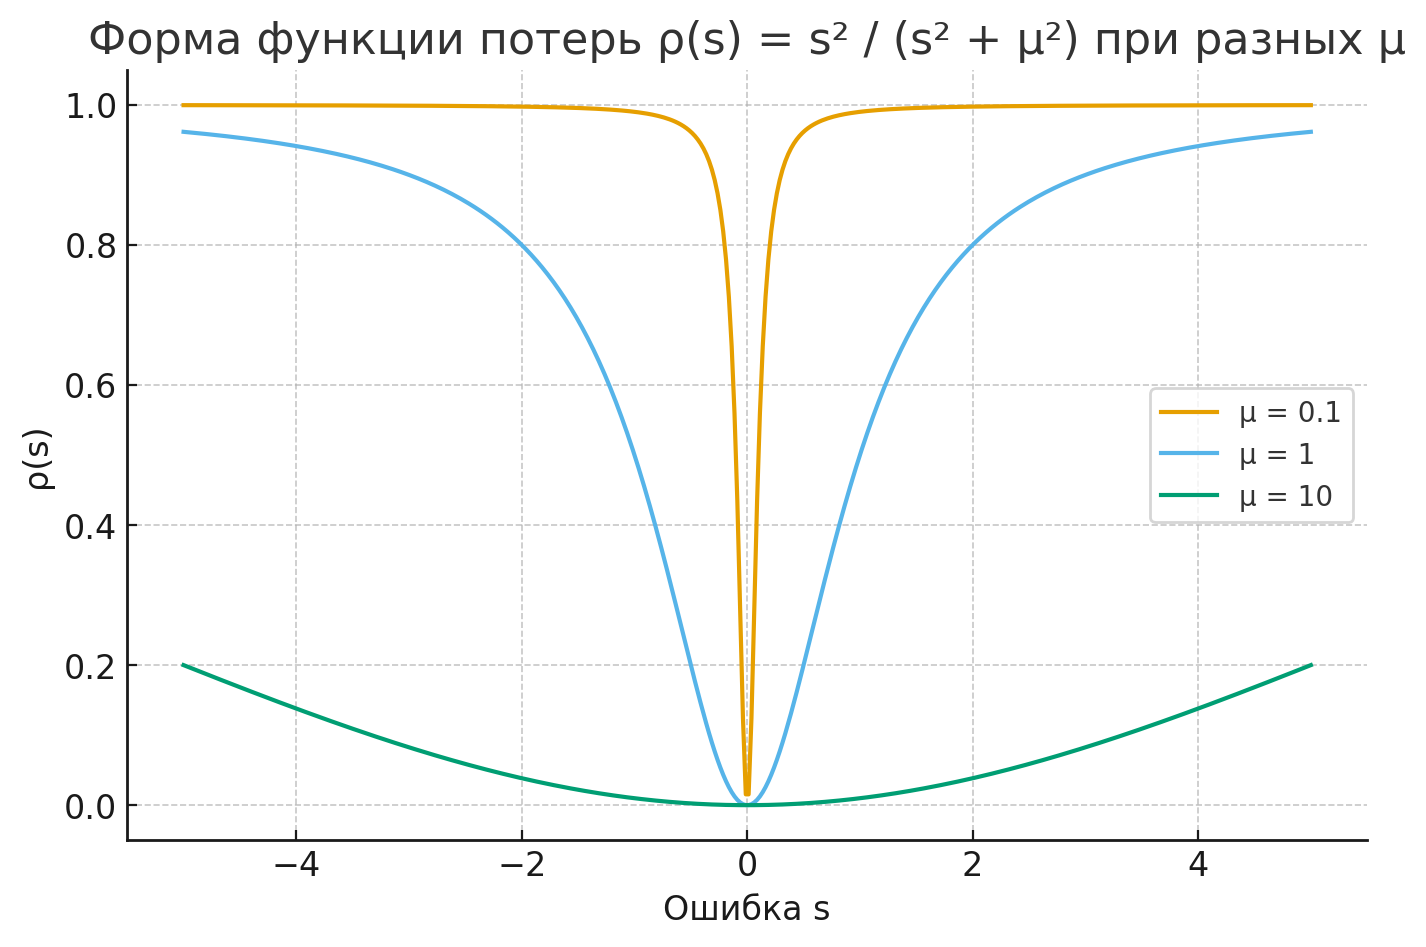

### Извлечение геометрических признаков

Сначала выполняется даунсэмплинг облака точек, затем вычисляются нормали. После этого для каждой точки рассчитывается дескриптор **FPFH (Fast Point Feature Histogram)**.

* FPFH — это 33-мерный вектор, описывающий локальные геометрические свойства точки (распределение нормалей и относительных положений соседних точек).
* Поиск ближайших соседей в этом 33-мерном пространстве позволяет находить точки с похожими локальными геометрическими структурами.


### Сигнатура метода  compute_fpfh_feature()

```
o3d.pipelines.registration.compute_fpfh_feature(
    pcd: open3d.geometry.PointCloud,
    search_param: open3d.geometry.KDTreeSearchParam
) -> open3d.pipelines.registration.Feature
```

### Аргументы

1. **`pcd`** (`open3d.geometry.PointCloud`)
   Облако точек, для которого вычисляются признаки.

   * У облака **обязательно должны быть рассчитаны нормали** (`estimate_normals`), иначе метод выдаст ошибку.
   * Обычно сначала делают даунсэмплинг (`voxel_down_sample`), чтобы ускорить расчёт.

2. **`search_param`** (`open3d.geometry.KDTreeSearchParam`)
   Параметры поиска соседей. Поддерживаются варианты:

   * `o3d.geometry.KDTreeSearchParamHybrid(radius, max_nn)`

     * `radius` — радиус поиска соседей,
     * `max_nn` — максимальное количество ближайших соседей.
   * `o3d.geometry.KDTreeSearchParamKNN(knn)` — фиксированное число соседей.
   * `o3d.geometry.KDTreeSearchParamRadius(radius)` — поиск всех соседей в пределах радиуса.

   Чаще всего используют **Hybrid**, так как он сочетает радиус поиска и ограничение по числу соседей.

### Возвращаемое значение

**`Feature`** (`open3d.pipelines.registration.Feature`)

* Матрица размера `33 × N`, где `N` — количество точек в облаке.
* Каждый столбец — это 33-мерный FPFH-вектор для соответствующей точки.

In [20]:
def preprocess_point_cloud(pcd, voxel_size):

    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2

    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5

    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

## Входные данные
Код ниже загружает исходное и целевое облака точек из двух файлов. В качестве преобразования используется единичная матрица, поэтому облака изначально несовмещены.

In [21]:
def prepare_dataset(voxel_size):

    demo_icp_pcds = o3d.data.DemoICPPointClouds()
    source = o3d.io.read_point_cloud(demo_icp_pcds.paths[0])
    target = o3d.io.read_point_cloud(demo_icp_pcds.paths[1])
    trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
    source.transform(trans_init)
    draw_registration_result(source, target, np.identity(4))

    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source, target, source_down, target_down, source_fpfh, target_fpfh

In [22]:
voxel_size = 0.05
source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(voxel_size)

### Сигнатура метода registration_ransac_based_on_feature_matching()

```
o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
    source: open3d.geometry.PointCloud,
    target: open3d.geometry.PointCloud,
    source_feature: open3d.pipelines.registration.Feature,
    target_feature: open3d.pipelines.registration.Feature,
    mutual_filter: bool,
    max_correspondence_distance: float,
    estimation_method: TransformationEstimation = TransformationEstimationPointToPoint(),
    ransac_n: int = 4,
    checkers: List[o3d.pipelines.registration.CorrespondenceChecker] = [],
    criteria: o3d.pipelines.registration.RANSACConvergenceCriteria = RANSACConvergenceCriteria()
) -> RegistrationResult
```

### Аргументы

1. **`source`** (`PointCloud`)
   Исходное облако точек, которое совмещается.

2. **`target`** (`PointCloud`)
   Целевое облако точек.

3. **`source_feature`** (`Feature`)
   Локальные признаки для исходного облака (например, результат `compute_fpfh_feature`).

4. **`target_feature`** (`Feature`)
   Локальные признаки для целевого облака.

5. **`mutual_filter`** (`bool`)

   * Если `True` - используется взаимная проверка при поиске ближайших соседей в пространстве признаков (match считается корректным только если точки совпадают в обоих направлениях).
   * Если `False` - проверка в одном направлении (быстрее, но менее надёжно).

6. **`max_correspondence_distance`** (`float`)
   Максимальное расстояние, допустимое для соответствующих точек после применения преобразования.

7. **`estimation_method`** (`TransformationEstimation`, по умолчанию `TransformationEstimationPointToPoint()`)
   
   Метод оценки трансформации:

   * `TransformationEstimationPointToPoint()`
   * `TransformationEstimationPointToPlane()`

8. **`ransac_n`** (`int`, по умолчанию 4)
   Количество случайных точек, выбираемых из исходного облака на каждой итерации RANSAC.

9. **`checkers`** (`list[CorrespondenceChecker]`)
   
   Список проверок для фильтрации ложных соответствий:

   * `CorrespondenceCheckerBasedOnDistance`
   * `CorrespondenceCheckerBasedOnEdgeLength`
   * `CorrespondenceCheckerBasedOnNormal`

10. **`criteria`** (`RANSACConvergenceCriteria`)
    
    Условия остановки RANSAC:

    * `max_iteration` — максимальное количество итераций,
    * `confidence` — доверительная вероятность (вероятность того, что решение близко к оптимальному).

11. **`confidence`**

    $
        k = \frac{\log(1 - p)}{\log(1 - w^n)}
    $

    * w — доля корректных соответствий.
    * n — число точек, необходимое для одной гипотезы.
    * p — желаемая уверенность (confidence).
    * k — минимальное число итераций, которое нужно сделать

---

### Возвращаемое значение

**`RegistrationResult`**, включающий:

* `transformation` — итоговая матрица преобразования (4×4),
* `fitness` — доля точек с корректными соответствиями,
* `inlier_rmse` — ошибка на inlier-совпадениях,
* `correspondence_set` — найденные соответствия.


In [23]:
def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, 
        [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)
        ],
        o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result

In [24]:
result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)

print(f'Fitness={round(result_ransac.fitness, 3)}')
print(f'Inlier_rmse={round(result_ransac.inlier_rmse, 3)}')
print(f'correspondence_set is {len(result_ransac.correspondence_set)}')
print(f'Transform:\n{result_ransac.transformation}')

draw_registration_result(source_down, target_down, result_ransac.transformation)

Fitness=0.67
Inlier_rmse=0.031
correspondence_set is 3190
Transform:
[[-0.51798462  0.85491978  0.02835665  0.54266231]
 [-0.23169991 -0.17214089  0.95743546  0.91843915]
 [ 0.82341186  0.48936661  0.28725117 -1.47583373]
 [ 0.          0.          0.          1.        ]]


### Локальное уточнение

Из соображений производительности глобальная регистрация выполняется только на сильно прореженном (downsampled) облаке точек. Такой результат получается грубым и не обеспечивает плотного совмещения.

Чтобы улучшить точность, применяется **Point-to-plane ICP**, который использует результат глобальной регистрации как начальное приближение и уточняет выравнивание до более плотного совпадения.


In [25]:
def refine_registration(source, target, voxel_size):
    distance_threshold = voxel_size * 0.4

    result = o3d.pipelines.registration.registration_icp(
        source, target, distance_threshold, result_ransac.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    return result

In [26]:
result_icp = refine_registration(source, target, voxel_size)

print(f'Fitness={round(result_icp.fitness, 3)}')
print(f'Inlier_rmse={round(result_icp.inlier_rmse, 3)}')
print(f'correspondence_set is {len(result_icp.correspondence_set)}')
print(f'Transform:\n{result_icp.transformation}')

draw_registration_result(source, target, result_icp.transformation)

Fitness=0.621
Inlier_rmse=0.007
correspondence_set is 123483
Transform:
[[-0.54181434  0.84047204  0.00663146  0.64486893]
 [-0.21675074 -0.14734376  0.96504349  0.80950778]
 [ 0.81206917  0.52143703  0.2620059  -1.48472184]
 [ 0.          0.          0.          1.        ]]


### Базовый вариант

В приведённом ниже коде измеряется время работы метода глобальной регистрации.

In [27]:
start = time.time()
result_ransac = execute_global_registration(source_down, target_down,
                                            source_fpfh, target_fpfh,
                                            voxel_size)
print("Global registration took %.3f sec.\n" % (time.time() - start))

print(f'Fitness={round(result_icp.fitness, 3)}')
print(f'Inlier_rmse={round(result_icp.inlier_rmse, 3)}')
print(f'correspondence_set is {len(result_icp.correspondence_set)}')
print(f'Transform:\n{result_icp.transformation}')

draw_registration_result(source_down, target_down, result_ransac.transformation)

Global registration took 0.250 sec.

Fitness=0.621
Inlier_rmse=0.007
correspondence_set is 123483
Transform:
[[-0.54181434  0.84047204  0.00663146  0.64486893]
 [-0.21675074 -0.14734376  0.96504349  0.80950778]
 [ 0.81206917  0.52143703  0.2620059  -1.48472184]
 [ 0.          0.          0.          1.        ]]


### Быстрая глобальная регистрация

#### Сигнатура `registration_fgr_based_on_feature_matching`

```python
o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
    source: open3d.geometry.PointCloud,
    target: open3d.geometry.PointCloud,
    source_feature: open3d.pipelines.registration.Feature,
    target_feature: open3d.pipelines.registration.Feature,
    option: o3d.pipelines.registration.FastGlobalRegistrationOption = 
        o3d.pipelines.registration.FastGlobalRegistrationOption()
) -> o3d.pipelines.registration.RegistrationResult
```


#### Аргументы

* **`source`**: `PointCloud` — исходное облако.
* **`target`**: `PointCloud` — целевое облако.
* **`source_feature`**: `Feature` — признаки для `source` (например, FPFH из `compute_fpfh_feature`).
* **`target_feature`**: `Feature` — признаки для `target`.
* **`option`**: `FastGlobalRegistrationOption` — параметры FGR.

#### `FastGlobalRegistrationOption`

* `division_factor: float = 1.4` — коэффициент «graduated non-convexity» (если `decrease_mu=True`, шагово уменьшает μ).
* `use_absolute_scale: bool = False` — абсолютная шкала расстояний (иначе — относительная к диаметру модели).
* `decrease_mu: bool = True` — уменьшать μ по мере итераций (ускоряет/стабилизирует сходимость).
* `maximum_correspondence_distance: float = 0.025` — макс. допустимая ошибка соответствий.
* `iteration_number: int = 64` — число итераций FGR.
* `tuple_scale: float = 0.95` — масштаб сравнения троек опорных точек.
* `maximum_tuple_count: int = 1000` — сколько троек пробовать.
* `tuple_test: bool = True` — включить геометрическую проверку троек на старте.

В приведённом ниже коде измеряется время работы метода быстрой глобальной регистрации.

In [28]:
def execute_fast_global_registration(source_down, target_down, source_fpfh,
                                     target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.5
    
    result = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh,
        o3d.pipelines.registration.FastGlobalRegistrationOption(
            maximum_correspondence_distance=distance_threshold))
    return result

In [29]:
start = time.time()
result_fast = execute_fast_global_registration(source_down, target_down,
                                               source_fpfh, target_fpfh,
                                               voxel_size)
print("Fast global registration took %.3f sec.\n" % (time.time() - start))

print(f'Fitness={round(result_fast.fitness, 3)}')
print(f'Inlier_rmse={round(result_fast.inlier_rmse, 3)}')
print(f'correspondence_set is {len(result_fast.correspondence_set)}')
print(f'Transform:\n{result_fast.transformation}')

draw_registration_result(source_down, target_down, result_fast.transformation)

Fast global registration took 0.279 sec.

Fitness=0.51
Inlier_rmse=0.017
correspondence_set is 2426
Transform:
[[-0.53949714  0.84197928  0.00370462  0.64383479]
 [-0.21867264 -0.14436037  0.96506081  0.80325097]
 [ 0.81309601  0.51983745  0.26199984 -1.47834505]
 [-0.          0.         -0.          1.        ]]


FGR работает значительно быстрее, чем RANSAC, так как использует всю совокупность соответствий одновременно и не требует многократного перебора подмножеств.

Однако он чувствительнее к плохой инициализации и может застрять в локальном минимуме при сильных смещениях между облаками.

## Типичный пайплайн

In [30]:
voxel_global = 0.02

salient_radius = 3 * voxel_global
non_max_radius = 2 * voxel_global
gamma_21 = 0.975
gamma_32 = 0.975
min_neighbors = 5

fpfh_radius = 5 * voxel_global

distance_threshold_ransac = 1.5 * voxel_global

voxel_scales   = [0.05, 0.02, 0.01]
dist_threshold = [0.15, 0.06, 0.03]
max_iters      = [60, 40, 20  ]

In [31]:
demo = o3d.data.DemoICPPointClouds()
source = o3d.io.read_point_cloud(demo.paths[0])
target = o3d.io.read_point_cloud(demo.paths[1])

In [32]:
src_ds = source.voxel_down_sample(voxel_global)
tgt_ds = target.voxel_down_sample(voxel_global)

src_ds.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_global*2.0, max_nn=30))
tgt_ds.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_global*2.0, max_nn=30))
src_ds.orient_normals_consistent_tangent_plane(50)
tgt_ds.orient_normals_consistent_tangent_plane(50)

In [33]:
iss_src = o3d.geometry.keypoint.compute_iss_keypoints(
    src_ds,
    salient_radius=salient_radius,
    non_max_radius=non_max_radius,
    gamma_21=gamma_21,
    gamma_32=gamma_32,
    min_neighbors=min_neighbors,
)
iss_tgt = o3d.geometry.keypoint.compute_iss_keypoints(
    tgt_ds,
    salient_radius=salient_radius,
    non_max_radius=non_max_radius,
    gamma_21=gamma_21,
    gamma_32=gamma_32,
    min_neighbors=min_neighbors,
)

o3d.visualization.draw_geometries([
    src_ds.paint_uniform_color([1,0.6,0]),
    iss_src.paint_uniform_color([1,0,0]),
    tgt_ds.paint_uniform_color([0,0.6,1]),
    iss_tgt.paint_uniform_color([0,0,1]),
])

In [34]:
iss_src.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_global*2.5, max_nn=50))
iss_tgt.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_global*2.5, max_nn=50))

In [35]:
fpfh_src = o3d.pipelines.registration.compute_fpfh_feature(
    iss_src,
    o3d.geometry.KDTreeSearchParamHybrid(radius=fpfh_radius, max_nn=100)
)
fpfh_tgt = o3d.pipelines.registration.compute_fpfh_feature(
    iss_tgt,
    o3d.geometry.KDTreeSearchParamHybrid(radius=fpfh_radius, max_nn=100)
)

In [36]:
ransac_result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
    iss_src, iss_tgt, fpfh_src, fpfh_tgt,
    mutual_filter=True,
    max_correspondence_distance=distance_threshold_ransac,
    estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
    ransac_n=3,
    checkers=[
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.8),
        o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(0.15),
    ],
    criteria=o3d.pipelines.registration.RANSACConvergenceCriteria(max_iteration=100000, confidence=0.999)
)

print("RANSAC fitness:", ransac_result.fitness, "inlier_rmse:", ransac_result.inlier_rmse)
print("RANSAC transformation:\n", ransac_result.transformation)

o3d.visualization.draw_geometries([
    source.transform(ransac_result.transformation.copy()).paint_uniform_color([1,0.6,0]),
    target.paint_uniform_color([0,0.6,1])
])


RANSAC fitness: 0.05285714285714286 inlier_rmse: 0.0236084825970097
RANSAC transformation:
 [[ 0.7733958   0.38649451 -0.5024748   0.0512895 ]
 [-0.50328538  0.85629985 -0.11599309  2.05834715]
 [ 0.38543841  0.34259679  0.85677574 -1.26173041]
 [ 0.          0.          0.          1.        ]]


In [37]:
T_ransac = ransac_result.transformation.copy()

In [38]:
v = voxel_scales[0]
th = dist_threshold[0]
it = max_iters[0]

src_l0 = source.voxel_down_sample(v)
tgt_l0 = target.voxel_down_sample(v)

src_l0.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=v*2.0, max_nn=30))
tgt_l0.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=v*2.0, max_nn=30))

reg_l0 = o3d.pipelines.registration.registration_icp(
    src_l0, tgt_l0, th, T_ransac,
    o3d.pipelines.registration.TransformationEstimationPointToPlane(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=it)
)
T = reg_l0.transformation.copy()

print(f"[L0] fitness={reg_l0.fitness:.3f} rmse={reg_l0.inlier_rmse:.3f}")
print(reg_l0.transformation)


[L0] fitness=0.698 rmse=0.034
[[ 0.92483035 -0.35465715 -0.13750323  1.15893976]
 [ 0.36811436  0.92554227  0.08867539 -1.00595857]
 [ 0.09581569 -0.1326266   0.98652397  0.03179918]
 [ 0.          0.          0.          1.        ]]


In [39]:
v = voxel_scales[1]
th = dist_threshold[1]
it = max_iters[1]

src_l1 = source.voxel_down_sample(v)
tgt_l1 = target.voxel_down_sample(v)

src_l1.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=v*2.0, max_nn=30))
tgt_l1.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=v*2.0, max_nn=30))

reg_l1 = o3d.pipelines.registration.registration_icp(
    src_l1, tgt_l1, th, T,
    o3d.pipelines.registration.TransformationEstimationPointToPlane(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=it)
)
T = reg_l1.transformation.copy()

print(f"[L1] fitness={reg_l1.fitness:.3f} rmse={reg_l1.inlier_rmse:.3f}")
print(reg_l1.transformation)


[L1] fitness=0.659 rmse=0.013
[[ 0.92485042 -0.35443755 -0.1379338   1.15461774]
 [ 0.36790816  0.92566769  0.08822079 -1.00373769]
 [ 0.0964121  -0.13233801  0.98650462  0.02845528]
 [ 0.          0.          0.          1.        ]]


In [40]:
v = voxel_scales[2]
th = dist_threshold[2]
it = max_iters[2]

src_l2 = source.voxel_down_sample(v)
tgt_l2 = target.voxel_down_sample(v)

src_l2.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=v*2.0, max_nn=30))
tgt_l2.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=v*2.0, max_nn=30))

reg_l2 = o3d.pipelines.registration.registration_icp(
    src_l2, tgt_l2, th, T,
    o3d.pipelines.registration.TransformationEstimationPointToPlane(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=it)
)
T = reg_l2.transformation.copy()

print(f"[L2] fitness={reg_l2.fitness:.3f} rmse={reg_l2.inlier_rmse:.3f}")
print(reg_l2.transformation)


[L2] fitness=0.638 rmse=0.008
[[ 0.92480285 -0.35459698 -0.13784293  1.15335908]
 [ 0.36806647  0.92559408  0.08833278 -1.00409493]
 [ 0.09626406 -0.13242576  0.9865073   0.02840645]
 [ 0.          0.          0.          1.        ]]


In [ ]:
tau_eval = 0.02
eval_res = o3d.pipelines.registration.evaluate_registration(source, target, tau_eval, T)

print(f"[Final Eval @ {tau_eval} m] fitness={eval_res.fitness:.3f}, inlier_rmse={eval_res.inlier_rmse:.3f}")
print("Final T:\n", T)

[Final Eval @ 0.02 m] fitness=0.621, inlier_rmse=0.007
Final T:
 [[ 0.92480285 -0.35459698 -0.13784293  1.15335908]
 [ 0.36806647  0.92559408  0.08833278 -1.00409493]
 [ 0.09626406 -0.13242576  0.9865073   0.02840645]
 [ 0.          0.          0.          1.        ]]


In [42]:
src_final = source.transform(T.copy())
o3d.visualization.draw_geometries([
    src_final.paint_uniform_color([1,0.6,0]),
    target.paint_uniform_color([0,0.6,1])
])

# Домашнее задание: Регистрация трёхмерных облаков точек

**Задание:**

1. Использовать облака точек, сгенерированные в предыдущем домашнем задании (геометрические фигуры: стол, пирамидки, снеговики, шестилучевая звезда и др.).
2. Объединить все эти фигуры в одну общую сцену, формируя комплексную композицию с пересечениями и различными масштабами.
3. Для каждой фигуры по отдельности выполнить задачу регистрации — попытаться найти её положение и ориентацию на общей сцене.

   * использовать **глобальную регистрацию** (например, RANSAC или Fast Global Registration) для получения первичного приближения;
   * выполнить **локальное уточнение** с помощью ICP (Iterative Closest Point);
   * оценить качество регистрации по метрикам **fitness** и **inlier RMSE**.
   * визуализировать найденные соответствия точек;

**Формат отчёта:**

Ноутбук и скриншот визуализации результатов регистрации.

### Hw1 primitives

In [3]:
points_num = 5000

In [4]:
# CUBE
mesh_cube = o3d.geometry.TriangleMesh.create_box(width=1.0,
                                                height=1.0,
                                                depth=1.0)
sppd_cube = mesh_cube.sample_points_poisson_disk(points_num)

sppd_cube.translate((1.5, 0, 0))
sppd_cube.paint_uniform_color((0.5, 0.1, 0.4))

# SPHERE
mesh_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=1.0)
sppd_sphere = mesh_sphere.sample_points_poisson_disk(points_num)

sppd_sphere.translate((2.5, 0, 0))
sppd_sphere.paint_uniform_color([0.2, 0.7, 0.4])


# CYLINDER
mesh_cylinder = o3d.geometry.TriangleMesh.create_cylinder(radius=0.3, height=2.0)
sppd_cylinder = mesh_cylinder.sample_points_poisson_disk(points_num)

sppd_cylinder.translate((1.5, 0, 0))
sppd_cylinder.paint_uniform_color([0.9, 0.3, 0.4])


# СONE
mesh_cone = o3d.geometry.TriangleMesh.create_cone(radius=1.0, height=2.0, resolution=20)
sppd_cone = mesh_cone.sample_points_poisson_disk(points_num)

sppd_cone.translate((3, 0, 0))
sppd_cone.paint_uniform_color([0.1, 0.3, 0.9])


# TOUR
mesh_tour = o3d.geometry.TriangleMesh.create_torus(
    torus_radius=1.0,
    tube_radius=0.3,
    radial_resolution=30,
    tubular_resolution=20
)
sppd_tour = mesh_tour.sample_points_poisson_disk(points_num)

sppd_tour.translate((3, 0, 0))
sppd_tour.paint_uniform_color([0.5, 0.9, 0.1])



DisplayFigs.display_plotly_clouds((sppd_cube, sppd_sphere, sppd_cylinder, sppd_cone, sppd_tour), 1.5)

In [5]:
# SNOWMAN
# sppd_cube, sppd_cylinder, sppd_sphere, sppd_cone, sppd_tour

T_translate = np.array([
    [1.5, 0, 0, 1],
    [0, 1.5, 0, 0],
    [0, 0, 1.5, 0],
    [0, 0, 0, 1]
])

T_translate1 = np.array([
    [1, 0, 0, 2.3],
    [0, 1, 0, 0],
    [0, 0, 1, 2.5],
    [0, 0, 0, 1]
])

T_translate2 = np.array([
    [0.6, 0, 0, 3.3],
    [0, 0.6, 0, 0],
    [0, 0, 0.6, 4],
    [0, 0, 0, 1]
])

sppd_sphere_t = copy.deepcopy(sppd_sphere)
sppd_sphere_t.transform(T_translate)

sppd_sphere_t2 = copy.deepcopy(sppd_sphere)
sppd_sphere_t2.transform(T_translate1)

sppd_sphere_t3 = copy.deepcopy(sppd_sphere)
sppd_sphere_t3.transform(T_translate2)

sppd_sphere_t.paint_uniform_color([0.4, 0.9, 0.8])
sppd_sphere_t2.paint_uniform_color([0.4, 0.9, 0.8])
sppd_sphere_t3.paint_uniform_color([0.4, 0.9, 0.8])

snowman = sppd_sphere_t + sppd_sphere_t2 + sppd_sphere_t3

# o3d.visualization.draw_geometries([sppd_sphere_t, sppd_sphere_t2, sppd_sphere_t3])
DisplayFigs.display_plotly_clouds((snowman, ))


In [6]:
# TABLE
sppd_cube_t = copy.deepcopy(sppd_cube)
sppd_cube_t.transform([
    [0.3, 0, 0, -0.4],
    [0, 0.2, 0, 0],
    [0, 0, 0.01, 0],
    [0, 0, 0, 1]
])

sppd_cylinder_t1 = copy.deepcopy(sppd_cylinder)
sppd_cylinder_t1.transform([
    [0.03, 0, 0, 0.02],
    [0, 0.03, 0, 0.02],
    [0, 0, 0.07, -0.07],
    [0, 0, 0, 1]
])

sppd_cylinder_t2 = copy.deepcopy(sppd_cylinder)
sppd_cylinder_t2.transform([
    [0.03, 0, 0, 0.02],
    [0, 0.03, 0, 0.18],
    [0, 0, 0.07, -0.07],
    [0, 0, 0, 1]
])

sppd_cylinder_t3 = copy.deepcopy(sppd_cylinder)
sppd_cylinder_t3.transform([
    [0.03, 0, 0, 0.28],
    [0, 0.03, 0, 0.18],
    [0, 0, 0.07, -0.07],
    [0, 0, 0, 1]
])

sppd_cylinder_t4 = copy.deepcopy(sppd_cylinder)
sppd_cylinder_t4.transform([
    [0.03, 0, 0, 0.28],
    [0, 0.03, 0, 0.02],
    [0, 0, 0.07, -0.07],
    [0, 0, 0, 1]
])

sppd_cube_t.paint_uniform_color([0.8, 0.4, 0.2])
sppd_cylinder_t1.paint_uniform_color([0.0, 0.0, 0.0])
sppd_cylinder_t2.paint_uniform_color([0.0, 0.0, 0.0])
sppd_cylinder_t3.paint_uniform_color([0.0, 0.0, 0.0])
sppd_cylinder_t4.paint_uniform_color([0.0, 0.0, 0.0])

table = sppd_cube_t + sppd_cylinder_t1 + sppd_cylinder_t2 + sppd_cylinder_t3 + sppd_cylinder_t4

# o3d.visualization.draw_geometries([sppd_cube_t, sppd_cylinder_t1, sppd_cylinder_t2, sppd_cylinder_t3, sppd_cylinder_t4])
DisplayFigs.display_plotly_clouds((table, ))


In [7]:
# PYRAMID
sppd_cube_t = copy.deepcopy(sppd_cube)
sppd_cube_t.transform([
    [0.5, 0, 0, -0.6],
    [0, 0.5, 0, 0],
    [0, 0, 0.5, 0],
    [0, 0, 0, 1]
])

sppd_cube_t1 = copy.deepcopy(sppd_cube)
sppd_cube_t1.transform([
    [0.5, 0, 0, 0],
    [0, 0.5, 0, 0],
    [0, 0, 0.5, 0],
    [0, 0, 0, 1]
])

sppd_cube_t2 = copy.deepcopy(sppd_cube)
sppd_cube_t2.transform([
    [0.5, 0, 0, 0.6],
    [0, 0.5, 0, 0],
    [0, 0, 0.5, 0],
    [0, 0, 0, 1]
])

sppd_cube_t3 = copy.deepcopy(sppd_cube)
sppd_cube_t3.transform([
    [0.5, 0, 0, 0.3],
    [0, 0.5, 0, 0],
    [0, 0, 0.5, 0.5],
    [0, 0, 0, 1]
])

sppd_cube_t4 = copy.deepcopy(sppd_cube)
sppd_cube_t4.transform([
    [0.5, 0, 0, -0.3],
    [0, 0.5, 0, 0],
    [0, 0, 0.5, 0.5],
    [0, 0, 0, 1]
])

sppd_cube_t5 = copy.deepcopy(sppd_cube)
sppd_cube_t5.transform([
    [0.5, 0, 0, 0],
    [0, 0.5, 0, 0],
    [0, 0, 0.5, 1],
    [0, 0, 0, 1]
])

sppd_cone_t6 = copy.deepcopy(sppd_cone)
sppd_cone_t6.transform([
    [0.25, 0, 0, 0.25],
    [0, 0.25, 0, 0.25],
    [0, 0, 0.25, 1.5],
    [0, 0, 0, 1]
])

sppd_cube_t.paint_uniform_color([0.0, 0.5, 0.2]) # green
sppd_cube_t1.paint_uniform_color([0.2, 0.0, 0.4]) # purple
sppd_cube_t2.paint_uniform_color([0.7, 0.3, 0.0]) # orange
sppd_cube_t3.paint_uniform_color([0.1, 0.1, 0.9]) # blue
sppd_cube_t4.paint_uniform_color([0.9, 0.6, 0.3]) # brown
sppd_cube_t5.paint_uniform_color([0.9, 0.8, 0.3]) # yellow
sppd_cone_t6.paint_uniform_color([0.7, 0.0, 0.0]) # red

pyramid = sppd_cube_t + sppd_cube_t1 + sppd_cube_t2 + sppd_cube_t3 + sppd_cube_t4 + sppd_cube_t5 + sppd_cone_t6

# o3d.visualization.draw_geometries([sppd_cube_t, sppd_cube_t1, sppd_cube_t2, sppd_cube_t3, sppd_cube_t4, sppd_cube_t5, sppd_cone_t6])
DisplayFigs.display_plotly_clouds((pyramid, ))


In [8]:
# STAR
sppd_cylinder_t1 = copy.deepcopy(sppd_cylinder)
sppd_cylinder_t1.transform([
    [0.5, 0, 0, 0],
    [0, 0.5, 0, 0],
    [0, 0, 0.9, 0],
    [0, 0, 0, 1]
])

sppd_cylinder_t2 = copy.deepcopy(sppd_cylinder)
sppd_cylinder_t2.transform([
    [0.5, 0, 1, 0],
    [0, 0.5, 0, 0],
    [0, 0, 0.8, 0],
    [0, 0, 0, 1]
])

sppd_cylinder_t3 = copy.deepcopy(sppd_cylinder)
sppd_cylinder_t3.transform([
    [0.5, 0, -1, 0],
    [0, 0.5, 0, 0],
    [0, 0, 0.8, 0],
    [0, 0, 0, 1]
])

sppd_cylinder_t1.paint_uniform_color([0.8, 0.7, 0.0])
sppd_cylinder_t2.paint_uniform_color([0.8, 0.7, 0.0])
sppd_cylinder_t3.paint_uniform_color([0.8, 0.7, 0.0])

star = sppd_cylinder_t1 + sppd_cylinder_t2 + sppd_cylinder_t3

# o3d.visualization.draw_geometries([sppd_cylinder_t1, sppd_cylinder_t2,sppd_cylinder_t3])
DisplayFigs.display_plotly_clouds((star, ))


### Registration pipline

In [ ]:
import math

snowman_transform = deepcopy(snowman)
table_transform = deepcopy(table)
star_transform = deepcopy(star)
pyramid_transform = deepcopy(pyramid)


snowman_transform.transform([
    [0.3, 0,   0,   -0.4],
    [0,   0.2, 0,    0.2],
    [0,   0,   0.3,  0], 
    [0,   0,   0,    1]
])

table_transform.transform([
    [1.5, 0,   0,    -0.3], 
    [0,   1.4, 0,   -0.1],
    [0,   0,   1.2,  0],
    [0,   0,   0,    1]
])


angle = math.radians(45) 
cos_a, sin_a = math.cos(angle), math.sin(angle)
star_transform.transform([
    [0.1*cos_a, -0.1*sin_a, 0, 0.6],
    [0.1*sin_a,  0.1*cos_a, 0, 0.3],
    [0,         0,          1.1, 0.3],
    [0,         0,          0,   1]
])

angle_pyr = math.radians(-30)
cos_p, sin_p = math.cos(angle_pyr), math.sin(angle_pyr)
pyramid_transform.transform([
    [0.25*cos_p,  0,   0.25*sin_p,  -0.3],
    [0,          0.3,  0,           -0.1],
    [-0.25*sin_p, 0,   0.25*cos_p,   0.2],
    [0,          0,    0,            1]
])

main_scene = snowman_transform + table_transform + star_transform + pyramid_transform

DisplayFigs.display_plotly_clouds((main_scene, ))


REFERENCE SCENCE


In [10]:
def prepare_point_cloud(pcd, voxel_size):
    '''Downsampling for fast and local geometric properties of points 
    (distribution of normals and relative positions of reference points)'''
    pcd_down = pcd.voxel_down_sample(voxel_size)
    radius_normal = voxel_size * 2
    pcd_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
    radius_feature = voxel_size * 5
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh


def execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size):
    '''Global registration'''
    distance_threshold = voxel_size * 1.5
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False), 4,
        [o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
         o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
        o3d.pipelines.registration.RANSACConvergenceCriteria(4000000, 500))
    return result

def refine_registration(source, target, voxel_size, initial_transformation):
    '''Local ICP'''
    source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*2.0, max_nn=30))
    target.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size*2.0, max_nn=30))
    
    distance_threshold = voxel_size * 0.4
    result = o3d.pipelines.registration.registration_icp(
        source, target, distance_threshold,
        initial_transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    return result

In [11]:
def pipline(source_pcd, target_pcd, voxel_size=0.05, is_show=True):
    source_down, source_fpfh = prepare_point_cloud(source_pcd, voxel_size)
    target_down, target_fpfh = prepare_point_cloud(target_pcd, voxel_size)

    global_result = execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)

    print("Global registration fitness:", global_result.fitness)
    print("Global registration inlier RMSE:", global_result.inlier_rmse)

    refined_result = refine_registration(source_pcd, target_pcd, voxel_size, global_result.transformation)

    print("Refined registration fitness:", refined_result.fitness)
    print("Refined registration inlier RMSE:", refined_result.inlier_rmse)

    if is_show:
        source_pcd_ = deepcopy(source_pcd)
        source_pcd_.transform(refined_result.transformation)
        source_pcd_.paint_uniform_color([0.9, 0.0, 0.0])

        display(DisplayFigs.display_plotly_clouds((target_pcd, source_pcd_)))

    return source_down, target_down, refined_result

In [ ]:
source_down, target_down, refined_result = pipline(table_transform, main_scene)

TABLE

Global registration fitness: 1.0

Global registration inlier RMSE: 0.011780540222934812

Refined registration fitness: 1.0

Refined registration inlier RMSE: 7.401843982487498e-17

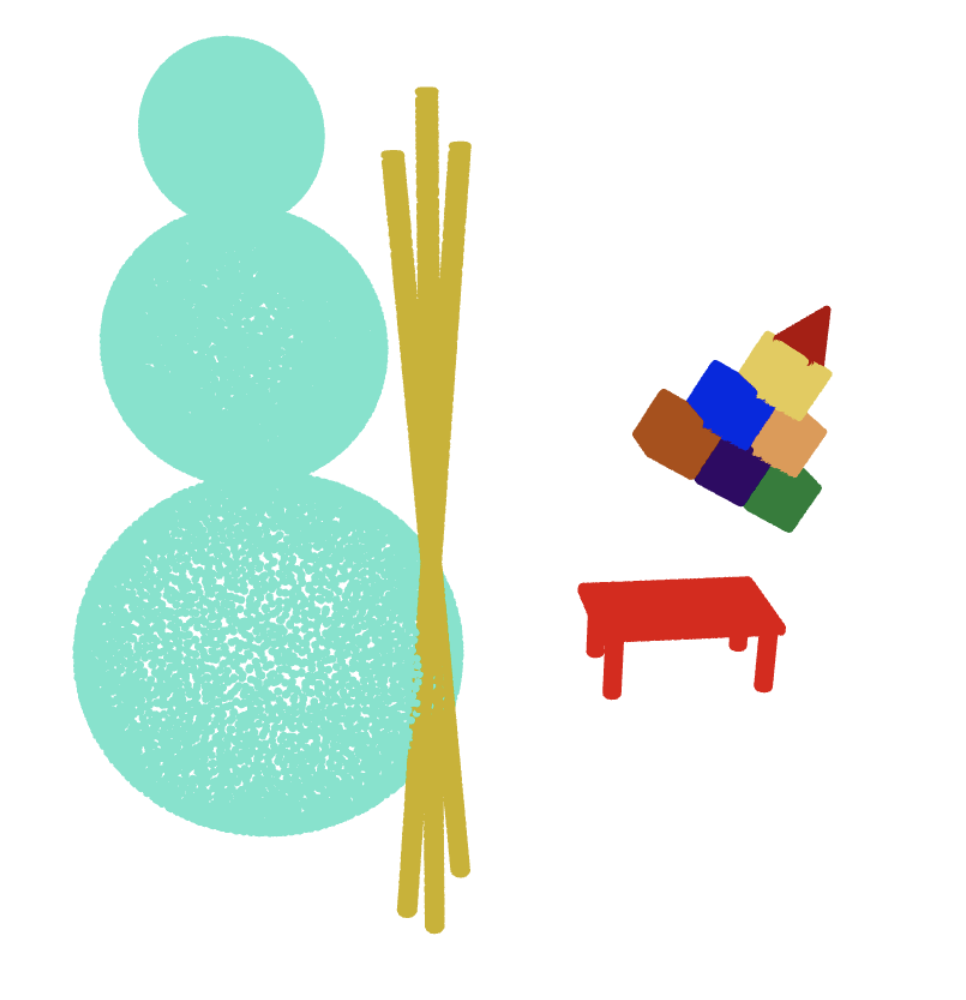

In [ ]:
source_down, target_down, refined_result = pipline(snowman_transform, main_scene)

SNOWMAN

Global registration fitness: 1.0

Global registration inlier RMSE: 0.012261218786271205

Refined registration fitness: 1.0

Refined registration inlier RMSE: 1.0204434139764613e-15

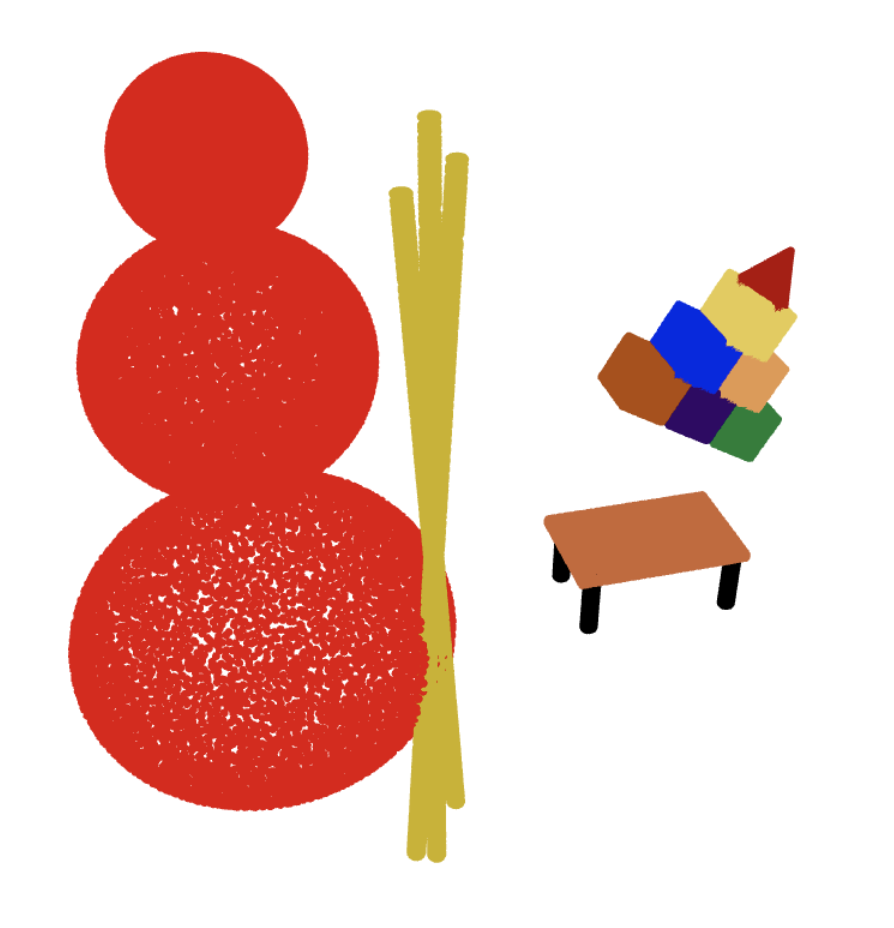

In [ ]:
source_down, target_down, refined_result = pipline(star_transform, main_scene)

STAR

Global registration fitness: 0.19291338582677164

Global registration inlier RMSE: 0.04132270474555759

Refined registration fitness: 0.8096666666666666

Refined registration inlier RMSE: 0.008354501690477715

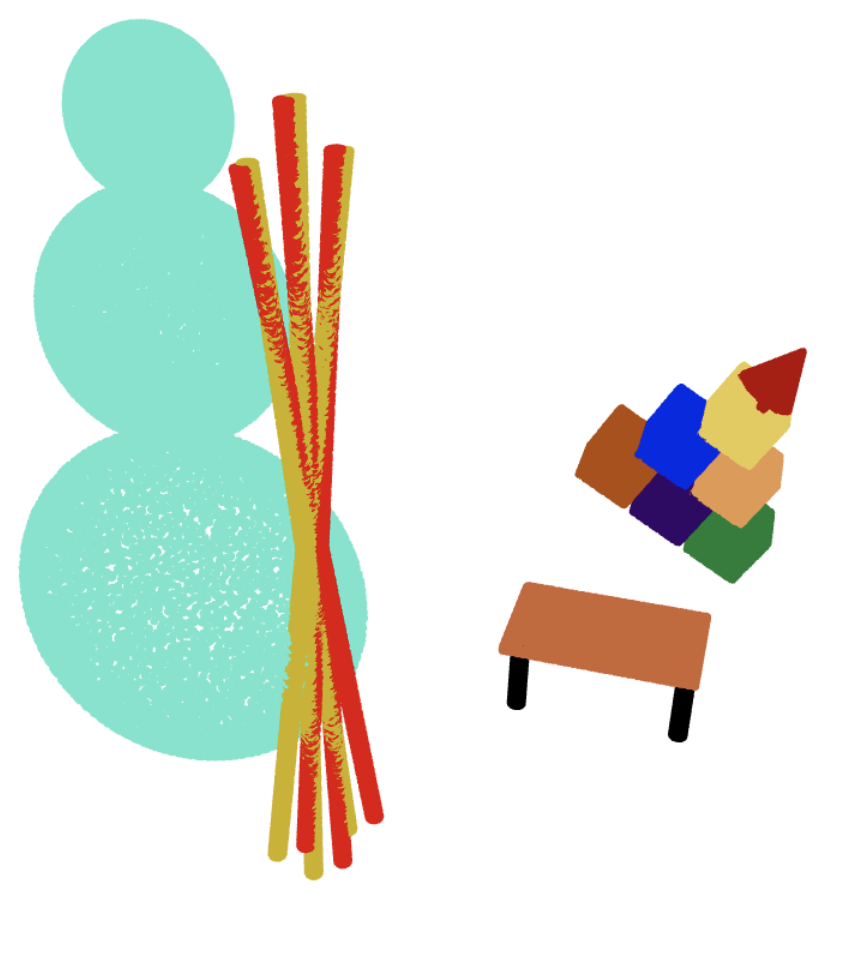

In [ ]:
source_down, target_down, refined_result = pipline(pyramid_transform, main_scene)

PYRAMID

Global registration fitness: 1.0

Global registration inlier RMSE: 0.008474623572104744

Refined registration fitness: 1.0

Refined registration inlier RMSE: 4.0244586990557465e-16

